In [1]:
import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, urllib, IPython.display
import essentia
import numpy as np
import librosa.display
import signal
plt.rcParams['figure.figsize'] = (14,4)

from scipy.signal import butter, lfilter, freqz

import glob
from pathlib import Path, PurePath

import essentia
import essentia.standard as es
import essentia.streaming as ess
from essentia.standard import *


from pylab import plot, show, figure, imshow
%matplotlib inline

#full array conversion to text! no truncation
np.set_printoptions(threshold=np.inf)

filelist = []

for filename in Path('music').glob('**/*.mp3'):
    filelist.append(filename)
    
for filename in Path('music').glob('**/*.wav'):
    filelist.append(filename)
    
path = str(PurePath(filelist[4]))

path = ('music/guitar2.mp3')

print(path)
fs = 44100

IndexError: list index out of range

In [2]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [13]:
def compute_features(path):
    # Loading audio file
    #will resample if sampleRate is different!
    audio = es.MonoLoader(filename=path, sampleRate=fs)()
    #will resample if sampleRate is different!
    loader = ess.MonoLoader(filename=path, sampleRate=44100)
    # Initialize algorithms we will use
    frameSize = 4096#512
    hopSize = 2048#256

    #will resample if sampleRate is different!

    #######################################
    # DO FILTERING ONLY FOR MFCC - not with essentia standard
    # below is just an example
    
    #HP = es.HighPass(cutoffFrequency=128)
    #LP = es.LowPass(cutoffFrequency=4096)
    #lp_f = LP(audio)
    #hp_f = HP(lp_f)
    #audio = hp_f
    #MonoWriter(filename='music/filtered.wav')(filtered_audio)

    HP = ess.HighPass(cutoffFrequency=128)
    LP = ess.LowPass(cutoffFrequency=4096)
    
    #loader = ess.MonoLoader(filename=path, sampleRate=44100)
    #writer = ess.MonoWriter(filename='music/filtered.wav')
    #frameCutter = FrameCutter(frameSize = 1024, hopSize = 512)
    #pool = essentia.Pool()
    # Connect streaming algorithms
    #loader.audio >> HP.signal
    #HP.signal >> LP.signal
    #LP.signal >> writer.audio
    # Run streaming network
    #essentia.run(loader)
    
    #####################################
    # extract mfcc
    #####################################

    #features, features_frames = es.MusicExtractor(analysisSampleRate=44100, mfccStats=['mean', 'cov'])(path)
    #m, n = features['lowlevel.mfcc.cov'].shape
    #print m
    #iu1 = np.triu_indices(m)
    #cov = features['lowlevel.mfcc.cov'][iu1]
    #mean = features['lowlevel.mfcc.mean']
    #print(features['lowlevel.mfcc.cov'])
    
    hamming_window = es.Windowing(type='hamming')
    spectrum = es.Spectrum()  # we just want the magnitude spectrum
    mfcc = es.MFCC(numberCoefficients=13)
    frame_sz = 2048#512
    hop_sz = 1024#256
    mfccs = numpy.array([mfcc(spectrum(hamming_window(frame)))[1]
                   for frame in es.FrameGenerator(audio, frameSize=frame_sz, hopSize=hop_sz)])

    #Let's scale the MFCCs such that each coefficient dimension has zero mean and unit variance:
    #mfccs = sklearn.preprocessing.scale(mfccs)
    #print mfccs.shape

    mean = numpy.mean(mfccs.T, axis=1)
    #print(mean)
    var = numpy.var(mfccs.T, axis=1)
    #print(var)
    cov = numpy.cov(mfccs.T)

    #get only upper triangular matrix values to shorten length
    iu1 = np.triu_indices(12)
    cov = cov[iu1]

    plt.imshow(mfccs.T, origin='lower', aspect='auto', interpolation='nearest')
    plt.ylabel('MFCC Coefficient Index')
    plt.xlabel('Frame Index')    
    plt.colorbar()
    
    #####################################
    # extract beat features and histogram
    #####################################

    # Compute beat positions and BPM
    rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
    bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)
    peak1_bpm, peak1_weight, peak1_spread, peak2_bpm, peak2_weight, peak2_spread, histogram = BpmHistogramDescriptors()(beats_intervals)

    tempo = bpm
    times = beats
    beats_frames = (beats * fs) / hopSize
    beats_frames = beats_frames.astype(int)
    
    fig, ax = plt.subplots()
    ax.bar(range(len(histogram)), histogram, width=1)
    ax.set_xlabel('BPM')
    ax.set_ylabel('Frequency')
    plt.title("BPM histogram")
    ax.set_xticks([20 * x + 0.5 for x in range(int(len(histogram) / 20))])
    ax.set_xticklabels([str(20 * x) for x in range(int(len(histogram) / 20))])
    plt.show()
    
    #####################################
    # extract full beat aligned chroma
    #####################################
    
    framecutter = ess.FrameCutter(frameSize=frameSize, hopSize=hopSize, silentFrames='noise')
    windowing = ess.Windowing(type='blackmanharris62')
    spectrum = ess.Spectrum()
    spectralpeaks = ess.SpectralPeaks(orderBy='magnitude',
                                      magnitudeThreshold=0.00001,
                                      minFrequency=20,
                                      maxFrequency=3500,
                                      maxPeaks=60)
    # Use default HPCP parameters for plots, however we will need higher resolution
    # and custom parameters for better Key estimation
    hpcp = ess.HPCP()
    hpcp_key = ess.HPCP(size=36, # we will need higher resolution for Key estimation
                        referenceFrequency=440, # assume tuning frequency is 44100.
                        bandPreset=False,
                        minFrequency=20,
                        maxFrequency=3500,
                        weightType='cosine',
                        nonLinear=False,
                        windowSize=1.)
    key = ess.Key(profileType='edma', # Use profile for electronic music
                  numHarmonics=4,
                  pcpSize=36,
                  slope=0.6,
                  usePolyphony=True,
                  useThreeChords=True)
    # Use pool to store data
    pool = essentia.Pool()
    # Connect streaming algorithms
    
    ###################################
    # USE FILTER - comment next lines in
    
    loader.audio >> HP.signal
    HP.signal >> LP.signal
    LP.signal >> framecutter.signal
    ###################################
    
    ###################################
    # NO FILTER - comment next line in
    #loader.audio >> framecutter.signal        
    ###################################
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    spectralpeaks.magnitudes >> hpcp_key.magnitudes
    spectralpeaks.frequencies >> hpcp_key.frequencies
    hpcp_key.hpcp >> key.pcp
    hpcp.hpcp >> (pool, 'tonal.hpcp')
    key.key >> (pool, 'tonal.key_key')
    key.scale >> (pool, 'tonal.key_scale')
    key.strength >> (pool, 'tonal.key_strength')
    # Run streaming network
    essentia.run(loader)
    #print("Estimated key and scale:", pool['tonal.key_key'] + " " + pool['tonal.key_scale'])
    #print(pool['tonal.hpcp'].T)
    chroma = pool['tonal.hpcp'].T

    # Plot HPCP
    imshow(pool['tonal.hpcp'].T, aspect='auto', origin='lower', interpolation='none')
    plt.title("HPCPs in frames (the 0-th HPCP coefficient corresponds to A)")
    show()
    
    #print beats_frames.shape[0]
    chroma_matrix = np.zeros((beats_frames.shape[0], 12))
    
    prev_beat = 0
    act_beat = 0
    sum_key = np.zeros(12)
    chroma_align = chroma
    chroma_align = chroma_align.transpose()
    mat_index = 0
    for i in beats_frames:
        act_beat = i
        value = sum(chroma_align[prev_beat:act_beat])/(act_beat-prev_beat)
        chroma_align[prev_beat:act_beat] = value
        prev_beat = i
        chroma_matrix[mat_index] = value
        mat_index = mat_index + 1
        
    chroma_align = chroma_align.transpose()   
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma_align, y_axis='chroma', x_axis='time')
    plt.vlines(times, 0, 12, alpha=0.5, color='r', linestyle='--', label='Beats')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()

    chroma_align = chroma_align.transpose()
    
    
    print(chroma_align[24:28])
    #####################################
    # extract full chroma text
    #####################################
    
    #print(chroma.shape)
    m, n = chroma.shape
    avg = 0
    chroma = chroma.transpose()
    m, n = chroma.shape
    for j in chroma:
        avg = avg + np.sum(j)
    avg = avg / m
    threshold = avg / 2
    for i in chroma:
        if np.sum(i) > threshold:
            ind = np.where(i == np.max(i))
            max_val = i[ind]#is always 1!
            i[ind] = 0
            
            ind2 = np.where(i == np.max(i))
            i[ind] = 1
            
            #if np.any(i[ind2][0] >= 0.8 * max_val):
                #i[ind2] = i[ind2]
                #pass
            #low_values_flags = i < 1
            low_values_flags = i < 0.8
            
            i[low_values_flags] = 0
        else:
            i.fill(0)     
    chroma = chroma.transpose()
    # Compute beat positions and BPM
    prev_beat = 0
    act_beat = 0
    sum_key = np.zeros(12)
    chroma = chroma.transpose()  
    for i in beats_frames:
        act_beat = i
        sum_key = sum(chroma[prev_beat:act_beat])
        #print(sum_key)
        #print(chroma[prev_beat:act_beat])

        ind = np.where(sum_key == np.max(sum_key))
        ind = ind[0]
        #print("debug")
        fill = np.zeros(len(j))
        if(np.all(chroma[prev_beat:act_beat] == 0)):
            fill[ind] = 0
        else:    
            fill[ind] = 1
        chroma[prev_beat:act_beat] = fill
        #print(chroma[prev_beat:act_beat])
        prev_beat = i
        #print("BEAT")
    
    notes = []
    for i in notes:
        del i
        
    prev_beat = 0
    act_beat = 0    
    for i in beats_frames:
        act_beat = i
        sum_key = sum(chroma[prev_beat:act_beat])
        ind = np.where(sum_key == np.max(sum_key))
        prev_beat = i
        notes.append(ind[0][0])
        prev_beat = i 
    chroma = chroma.transpose()  

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.vlines(times, 0, 12, alpha=0.5, color='r', linestyle='--', label='Beats')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()

    chroma = chroma.transpose()  
    
    return bpm, histogram, pool['tonal.key_key'], pool['tonal.key_scale'], notes, chroma_matrix, mean, cov


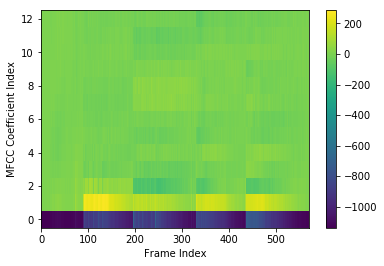

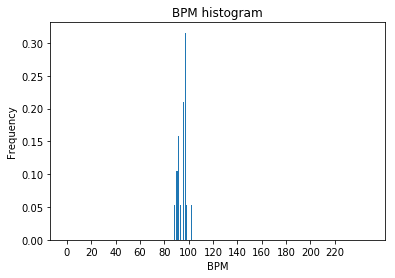

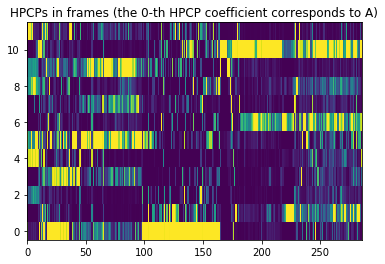

[[0.84204245 0.2664691  0.06457147 0.64466244 0.14557083 0.382868
  0.15356053 0.13123909 0.20519252 0.398251   0.12362785 0.3312278 ]
 [0.84204245 0.2664691  0.06457147 0.64466244 0.14557083 0.382868
  0.15356053 0.13123909 0.20519252 0.398251   0.12362785 0.3312278 ]
 [0.84204245 0.2664691  0.06457147 0.64466244 0.14557083 0.382868
  0.15356053 0.13123909 0.20519252 0.398251   0.12362785 0.3312278 ]
 [0.7431811  0.06587498 0.02696096 0.7892081  0.1896631  0.57935804
  0.11095666 0.06028787 0.1923501  0.2600882  0.06976978 0.2935893 ]]


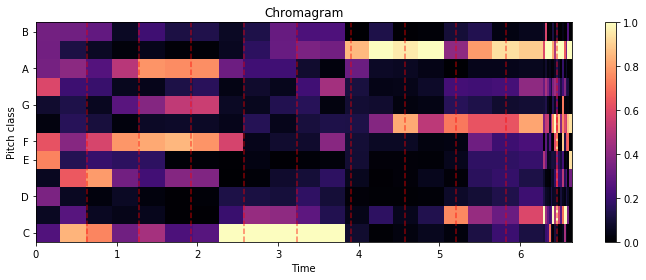

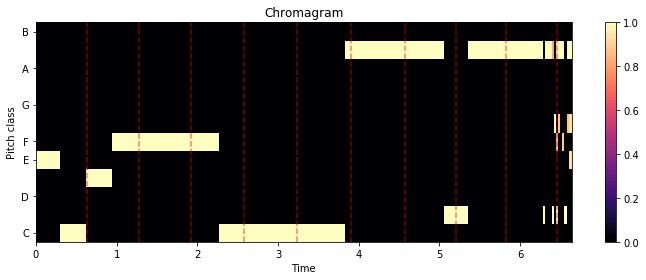

In [14]:
bpm, histogram, key, scale, notes, chroma_matrix, mean, cov = compute_features(path)

In [5]:
print(chroma_matrix)

[[0.25203007 0.0626901  0.35601303 0.05991574 0.74060255 0.62777287
  0.02877426 0.08696426 0.59010315 0.34085834 0.33500275 0.33873543]
 [0.84204245 0.26646909 0.06457147 0.64466244 0.14557083 0.38286799
  0.15356053 0.13123909 0.20519252 0.398251   0.12362785 0.33122781]
 [0.74318111 0.06587498 0.02696096 0.78920811 0.1896631  0.57935804
  0.11095666 0.06028787 0.1923501  0.26008821 0.06976978 0.29358929]
 [0.32822838 0.0433817  0.06855341 0.33287331 0.16686673 0.7804895
  0.02452408 0.27092031 0.05477703 0.50404    0.02067219 0.0675384 ]
 [0.45754051 0.05103247 0.02349698 0.21818341 0.17000343 0.81950265
  0.0711791  0.38038081 0.04716098 0.77658039 0.04851981 0.21011423]
 [0.24862626 0.00496024 0.00580555 0.35485515 0.01478711 0.88113868
  0.07815475 0.54320788 0.11602152 0.74360436 0.01453417 0.13105755]
 [0.25719085 0.00546224 0.01453198 0.39256254 0.01374786 0.75357592
  0.07077929 0.53051877 0.16598883 0.78056991 0.01488643 0.12914637]
 [0.99868238 0.19142374 0.11799355 0.00228

In [6]:
print histogram

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.05263158 0.
 0.         0.21052632 0.10526316 0.         0.05263158 0.
 0.10526316 0.         0.21052632 0.15789473 0.         

In [7]:
print key

G


In [8]:
print scale

minor


In [9]:
print notes

[4, 0, 3, 5, 5, 5, 9, 0, 0, 0, 0, 0, 10, 10, 10, 10, 1, 10, 10, 10]


In [10]:
print bpm

91.098815918


In [11]:
print mean

[-9.7823645e+02  1.1480081e+02 -2.1701511e+01 -1.8895168e+01
  6.8604422e-01 -1.6423550e+01 -1.4200696e+01  2.2541208e+00
  3.2243602e+00  2.0740244e-01 -2.7668786e+00 -1.3699087e+01
 -1.3363035e+01]


In [12]:
print cov

[ 1.26810509e+04  7.61063807e+03 -2.98861590e+03 -6.06244724e+02
  8.58371477e+02 -8.22416446e+02 -4.35923066e+02  5.38302493e+02
  3.15394592e+01 -2.46795071e+02 -8.48420237e+00 -7.40469112e+02
  5.88899182e+03 -8.93008466e+01 -2.75244602e+02  3.20337442e+02
 -2.75626747e+02 -3.69405975e+02 -2.24119618e+02 -4.14634937e+02
 -2.28012252e+02  1.57250911e+02 -1.58164008e+02  3.16617250e+03
  5.13532076e+02 -4.80199999e+02  5.32637485e+02  3.23529625e+00
 -9.27804982e+02 -6.86059466e+02 -1.17383580e+02  2.79639627e+02
  6.50714889e+02  4.01407417e+02  5.34957295e+01  9.65731391e+01
  1.84934446e+01 -1.77802014e+02 -2.23889414e+02 -9.74866850e+01
  1.60123118e+02  2.33426764e+02  2.88159252e+02 -6.53107350e+01
 -6.34261693e+01  9.96906765e+01 -1.18992330e+01 -4.46383672e+01
  7.57788077e+01 -4.52179179e-01  1.83570775e+02  5.77626600e+01
 -1.28192961e+02 -7.28901202e+01 -1.12899706e+01  3.13531517e+01
  1.12353193e+02  1.13182747e+02  7.05606578e+01  7.55378745e+01
  3.04303733e+01 -5.37599

In [ ]:
# Loading audio file
#will resample if sampleRate is different!
audio = es.MonoLoader(filename=path, sampleRate=fs)()

hamming_window = es.Windowing(type='hamming')
spectrum = es.Spectrum()  # we just want the magnitude spectrum
mfcc = es.MFCC(numberCoefficients=13)
frame_sz = 4096
hop_sz = 2048

mfccs = numpy.array([mfcc(spectrum(hamming_window(frame)))[1]
               for frame in es.FrameGenerator(audio, frameSize=frame_sz, hopSize=hop_sz)])
print mfccs.shape
m = mfccs.T.shape[1]

mean = numpy.mean(mfccs.T, axis=1)
#print(mean)
var = numpy.var(mfccs.T, axis=1)
#print(var)
cov = numpy.cov(mfccs.T)
iu1 = np.triu_indices(13)
cov = cov[iu1]

print mean

print cov

In [ ]:
#####################################
# extract mfcc
#####################################
# Loading audio file
#will resample if sampleRate is different!
audio = es.MonoLoader(filename=path, sampleRate=fs)()
# Initialize algorithms we will use
frameSize = 4096#512
hopSize = 2048#256

features, features_frames = es.MusicExtractor(analysisSampleRate=44100, mfccStats=['mean', 'cov'])(path)
m, n = features['lowlevel.mfcc.cov'].shape
print m
iu1 = np.triu_indices(m)
cov = features['lowlevel.mfcc.cov'][iu1]
mean = features['lowlevel.mfcc.mean']

print mean
print cov

In [ ]:
# Loading audio file

import essentia
import essentia.streaming as ess

loader = ess.MonoLoader(filename=path, sampleRate=44100)
writer = ess.MonoWriter(filename='music/filtered.wav')
# Initialize algorithms we will use
frameSize = 4096#512
hopSize = 2048#256

#will resample if sampleRate is different!

#MonoWriter(filename='music/filtered.wav')(filtered_audio)

HP = ess.HighPass(cutoffFrequency=128)
LP = ess.LowPass(cutoffFrequency=4096)

loader = ess.MonoLoader(filename=path, sampleRate=44100)
frameCutter = FrameCutter(frameSize = 1024, hopSize = 512)

pool = essentia.Pool()
# Connect streaming algorithms
loader.audio >> HP.signal
HP.signal >> LP.signal
LP.signal >> writer.audio
# Run streaming network

essentia.run(loader)



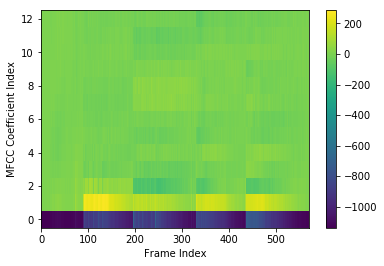

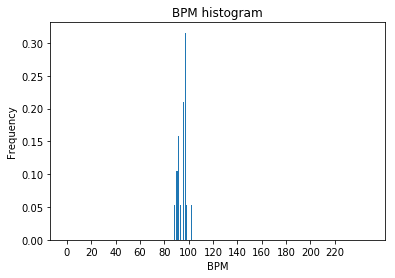

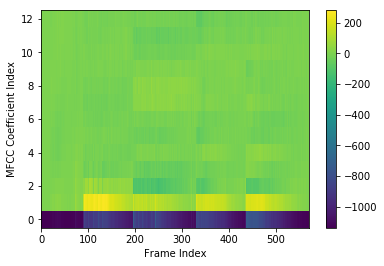

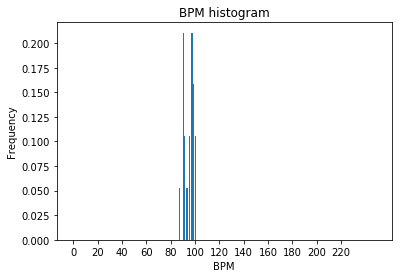

In [16]:
# Loading audio file
#will resample if sampleRate is different!
audio = es.MonoLoader(filename=path, sampleRate=fs)()
#will resample if sampleRate is different!
loader = ess.MonoLoader(filename=path, sampleRate=44100)
# Initialize algorithms we will use
frameSize = 4096#512
hopSize = 2048#256
hamming_window = es.Windowing(type='hamming')
spectrum = es.Spectrum()  # we just want the magnitude spectrum
mfcc = es.MFCC(numberCoefficients=13)
frame_sz = 2048#512
hop_sz = 1024#256
mfccs = numpy.array([mfcc(spectrum(hamming_window(frame)))[1]
               for frame in es.FrameGenerator(audio, frameSize=frame_sz, hopSize=hop_sz)])

#Let's scale the MFCCs such that each coefficient dimension has zero mean and unit variance:
#mfccs = sklearn.preprocessing.scale(mfccs)
#print mfccs.shape

mean = numpy.mean(mfccs.T, axis=1)
#print(mean)
var = numpy.var(mfccs.T, axis=1)
#print(var)
cov = numpy.cov(mfccs.T)

#get only upper triangular matrix values to shorten length
iu1 = np.triu_indices(12)
cov = cov[iu1]

plt.imshow(mfccs.T, origin='lower', aspect='auto', interpolation='nearest')
plt.ylabel('MFCC Coefficient Index')
plt.xlabel('Frame Index')    
plt.colorbar()

#####################################
# extract beat features and histogram
#####################################

# Compute beat positions and BPM
rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)
peak1_bpm, peak1_weight, peak1_spread, peak2_bpm, peak2_weight, peak2_spread, histogram = BpmHistogramDescriptors()(beats_intervals)

tempo = bpm
times = beats
beats_frames = (beats * fs) / hopSize
beats_frames = beats_frames.astype(int)

fig, ax = plt.subplots()
ax.bar(range(len(histogram)), histogram, width=1)
ax.set_xlabel('BPM')
ax.set_ylabel('Frequency')
plt.title("BPM histogram")
ax.set_xticks([20 * x + 0.5 for x in range(int(len(histogram) / 20))])
ax.set_xticklabels([str(20 * x) for x in range(int(len(histogram) / 20))])
plt.show()


HP = es.HighPass(cutoffFrequency=128)
LP = es.LowPass(cutoffFrequency=4096)
lp_f = LP(audio)
hp_f = HP(lp_f)
audio = hp_f
MonoWriter(filename='music/filtered.wav')(audio)

hamming_window = es.Windowing(type='hamming')
spectrum = es.Spectrum()  # we just want the magnitude spectrum
mfcc = es.MFCC(numberCoefficients=13)
frame_sz = 2048#512
hop_sz = 1024#256
mfccs = numpy.array([mfcc(spectrum(hamming_window(frame)))[1]
               for frame in es.FrameGenerator(audio, frameSize=frame_sz, hopSize=hop_sz)])

#Let's scale the MFCCs such that each coefficient dimension has zero mean and unit variance:
#mfccs = sklearn.preprocessing.scale(mfccs)
#print mfccs.shape

mean = numpy.mean(mfccs.T, axis=1)
#print(mean)
var = numpy.var(mfccs.T, axis=1)
#print(var)
cov = numpy.cov(mfccs.T)

#get only upper triangular matrix values to shorten length
iu1 = np.triu_indices(12)
cov = cov[iu1]

plt.imshow(mfccs.T, origin='lower', aspect='auto', interpolation='nearest')
plt.ylabel('MFCC Coefficient Index')
plt.xlabel('Frame Index')    
plt.colorbar()

#####################################
# extract beat features and histogram
#####################################

# Compute beat positions and BPM
rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)
peak1_bpm, peak1_weight, peak1_spread, peak2_bpm, peak2_weight, peak2_spread, histogram = BpmHistogramDescriptors()(beats_intervals)

tempo = bpm
times = beats
beats_frames = (beats * fs) / hopSize
beats_frames = beats_frames.astype(int)

fig, ax = plt.subplots()
ax.bar(range(len(histogram)), histogram, width=1)
ax.set_xlabel('BPM')
ax.set_ylabel('Frequency')
plt.title("BPM histogram")
ax.set_xticks([20 * x + 0.5 for x in range(int(len(histogram) / 20))])
ax.set_xticklabels([str(20 * x) for x in range(int(len(histogram) / 20))])
plt.show()
